In [1]:
# Module Import
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else :
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.7.0+cu101  Device: cuda


In [3]:
BATCH_SIZE = 128
EPOCHS = 90

## Dataset Loading (STL10)

In [4]:
# loading training dataset
from torchvision import datasets
import torchvision.transforms as transforms
import os

# specify a data path
path2data = '../data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load STL10 train dataset, and check
data_transformer = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.STL10(path2data, split='train', download=True, transform=data_transformer)
print(train_dataset.data.shape)

Extracting ../data/stl10_binary.tar.gz to ../data
(5000, 3, 96, 96)


In [5]:
# load STL10 test dataset
test_dataset = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test_dataset.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


## Normalization

In [6]:
meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_dataset]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_dataset]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [7]:
train_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(227),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
])

test_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
                transforms.Resize(227)
])

In [8]:
train_dataset.transform = train_transformer
test_dataset.transform = test_transformer

### Sample Data View

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3266
images indices:  3266


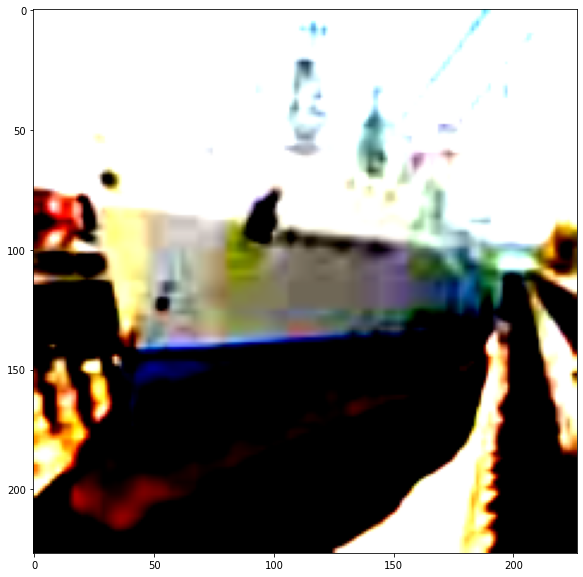

In [27]:
def show(img, y=None, color=True):

    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

# pick a random sample image 
rnd_inds = int(np.random.randint(0, len(train_dataset), 1))
print(rnd_inds)
img, label = train_dataset[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(10, 10))
show(img)

### Data Check

In [10]:
import collections
y_train = [y for _, y in train_dataset]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [40]:
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit splits indices of test0 in same proportion of labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test_dataset)))
y_test0 = [y for _,y in test_dataset]

for test_index, val_index in sss.split(indices, y_test0):
    print('Train :', len(test_index) , 'Test :', len(val_index))

Train : 6400 Test : 1600


In [12]:
from torch.utils.data import Subset

val_ds = Subset(test_dataset, val_index)
test_ds = Subset(test_dataset, test_index)

In [13]:
import collections
import numpy as np

y_test = [y for _, y in train_dataset]
y_val = [y for _, y in test_dataset]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})
Counter({6: 800, 7: 800, 5: 800, 0: 800, 3: 800, 1: 800, 4: 800, 9: 800, 2: 800, 8: 800})


### DataLoader

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model Parameter Calculate

In [16]:
def conv_output_size(input_size, kernel_size, padding_size, stride):
    output = (input_size - kernel_size + 2 * padding_size) / stride + 1
    return output

def maxpool_output_size(input_size, pooling_size, stride):
    output = (input_size - pooling_size) / stride + 1
    return output

In [17]:
# 1st conv output size
maxpool_output_size(conv_output_size(227, 11, 0, 4),3,2)

27.0

In [18]:
# 2nd conv+maxpooing output size
maxpool_output_size(conv_output_size(27,3,1,1),3,2)

13.0

In [19]:
# 3rd conv output size
conv_output_size(13,3,1,1)

13.0

In [20]:
# 4th conv output size
conv_output_size(13,3,1,1)

13.0

In [21]:
# 5th conv+maxpooing output size
maxpool_output_size(conv_output_size(13,3,1,1),3,2)

6.0

## Modeling Network

In [31]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.convLayer = nn.Sequential(
            # --- 1st Convolutional layer ---
            nn.Conv2d(in_channels = 3, 
                      out_channels = 96,
                      kernel_size = 11,
                      stride = 4),
            nn.ReLU(),
            nn.LocalResponseNorm(size = 5,
                                alpha = 0.0001,
                                beta = 0.75,
                                k = 2),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            # --- 2nd Convolutional layer ---
            nn.Conv2d(in_channels = 96,
                      out_channels = 256,
                      kernel_size = 5,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.LocalResponseNorm(size = 5,
                    alpha = 0.0001,
                    beta = 0.75,
                    k = 2),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            
            # --- 3rd Convolutional layer ---
            nn.Conv2d(in_channels = 256,
                     out_channels = 384,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            
            # --- 4th Convolutional layer ---
            nn.Conv2d(in_channels = 384,
                     out_channels = 384,
                     kernel_size = 3,
                     stride = 1,
                     padding = 1),
            nn.ReLU(),
            
            # --- 5th Convolutional layer ---
            nn.Conv2d(in_channels = 384,
                     out_channels = 256,
                     kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.fcLayer = nn.Sequential(
            # --- 1st Fully Connected layer ---
            nn.Dropout(p = 0.5),
            nn.Linear(256*6*6, 4096), # channel * size, output_channel
            nn.ReLU(),
            
            # --- 2nd Fully Connected layer ---
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),

            # --- Classification layer ---
            nn.Linear(in_features=4096, 
                      out_features=num_classes),
        )
        
    def init_bias_weights(self):
        for layer in self.convLayer:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)   # weight 초기화
                nn.init.constant_(layer.bias, 0)   # bias 초기화

            # conv 2, 4, 5는 bias 1로 초기화 
            nn.init.constant_(self.convLayer[4].bias, 1)
            nn.init.constant_(self.convLayer[10].bias, 1)
            nn.init.constant_(self.convLayer[12].bias, 1)
        
    def forward(self, x):
        x = self.convLayer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fcLayer(x)
        
        return x

In [32]:
model = AlexNet().to(device)

In [33]:
print(model)

AlexNet(
  (convLayer): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fcLayer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_fe

In [34]:
from torchsummary import summary
summary(model, input_size=(3, 227, 227), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 25, 25]         614,656
              ReLU-6          [-1, 256, 25, 25]               0
 LocalResponseNorm-7          [-1, 256, 25, 25]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]         885,120
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]       1,327,488
             ReLU-12          [-1, 384, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         884,992
             ReLU-14          [-1, 256,

## Training

In [35]:
optimizer = optim.SGD(
  params = model.parameters(),
  lr = 0.01,
  momentum = 0.9,
  weight_decay = 0.005  # lr 점점 감소
)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

loss_list = []
accuracy_list = []

for epoch in range(90):
    
    print('[epoch %d]' %epoch, end=' ')
    lr_scheduler.step()
    
    running_loss = 0.0
    correct = 0
    
    for imgs, classes in train_loader :
        
        imgs, classes = imgs.to(device), classes.to(device)
        
        optimizer.zero_grad()
        output = model(imgs)
        
        loss = F.cross_entropy(output, classes)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(classes.view_as(pred)).sum().item()
        
    cost = running_loss / len(train_loader)
    print('Train loss: %.3f | Train accuracy: %.2f%%' %(cost, 100.*correct/len(train_loader.dataset))) 
    loss_list.append(cost)
    accuracy_list.append(100.*correct/len(train_loader.dataset))

[epoch 0] 

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train loss: 2.303 | Train accuracy: 9.84%
[epoch 1] Train loss: 2.303 | Train accuracy: 9.48%
[epoch 2] Train loss: 2.302 | Train accuracy: 10.02%
[epoch 3] Train loss: 2.302 | Train accuracy: 12.92%
[epoch 4] Train loss: 2.301 | Train accuracy: 16.16%
[epoch 5] Train loss: 2.299 | Train accuracy: 12.98%
[epoch 6] Train loss: 2.288 | Train accuracy: 11.82%
[epoch 7] Train loss: 2.217 | Train accuracy: 16.44%
[epoch 8] Train loss: 2.044 | Train accuracy: 23.68%
[epoch 9] Train loss: 1.919 | Train accuracy: 26.46%
[epoch 10] Train loss: 1.906 | Train accuracy: 27.76%
[epoch 11] Train loss: 1.732 | Train accuracy: 30.08%
[epoch 12] Train loss: 1.865 | Train accuracy: 26.52%
[epoch 13] Train loss: 1.712 | Train accuracy: 32.04%
[epoch 14] Train loss: 1.677 | Train accuracy: 33.24%
[epoch 15] Train loss: 1.619 | Train accuracy: 34.86%
[epoch 16] Train loss: 1.606 | Train accuracy: 36.54%
[epoch 17] Train loss: 1.558 | Train accuracy: 38.34%
[epoch 18] Train loss: 1.578 | Train accuracy: 38.

In [36]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the test images: 59.51 %


In [37]:
x = np.arange(len(loss_list))

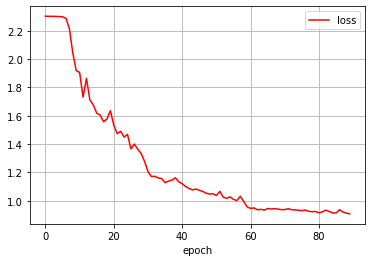

In [38]:
plt.plot(x, loss_list, c='red', label="loss")
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.show()

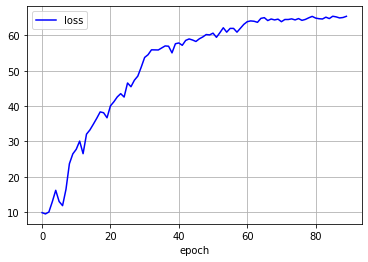

In [39]:
plt.plot(x, accuracy_list, c='blue', label="loss")
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.show()